In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [197]:
# %load ../main_module.py
# Standard Scientific Import
from IPython.display import display, HTML, Javascript, JSON
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
from scipy import stats
import seaborn as sns
sns.set()


# 导入数据

In [3]:
df_train = pd.read_csv('train.csv')

# 缺失值处理

In [19]:
na_count = df_train.isnull().sum().sort_values(ascending=False)

na_rate = na_count / len(df_train)

na_data = pd.concat([na_count, na_rate], axis=1, keys=['count', 'ratio'])

na_data.head(20)

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


统计发现，整个数据集中有19个特征有不同程序的缺失。
缺失数据达到15%以上，应该删除并认为数据集不存在这个的特征。

其余的GarageX开头的特征有相同的缺失值，可能代表同一组观测值，因此删除这几个特征。对BsmtX也进行相同的操作。
对于MasVnrArea和MasVnrType, 根据字面意思，可以认为不重要，并且与YearBuilt， OverallQual有较强的相关性，因此删除这两个特征。
总的来看， 除了Electrical，其他包含缺失值的变量都已经删除。只有一个缺失值，因此打算删除带有这个缺失值的样本。

In [156]:
df_train = df_train.drop(na_data[na_data['count']>1].index, axis=1)  # 删除上述前18个特征 

In [159]:
df_train = df_train.drop(df_train.loc[df_train["Electrical"].isnull()].index)  # 删除 Electrical 取值丢失的样本

In [160]:
df_train.shape

(1459, 63)

# 缺失值补全和变换

In [70]:
df_tr = pd.read_csv("train.csv").drop("Id", axis=1)

In [71]:
df_X = df_tr.drop("SalePrice",axis=1)

In [72]:
df_y = df_tr["SalePrice"]

In [73]:
quantity = [attr for attr in df_X.columns if df_X.dtypes[attr] != 'object'] ## 数值变量集合

In [74]:
quality = [attr for attr in df_X.columns if df_X.dtypes[attr] == 'object']  # 类型变量集合

In [75]:
for c in quality:
    df_tr[c] = df_tr[c].astype('category')
    if df_tr[c].isnull().any():
        df_tr[c] = df_tr[c].cat.add_categories(['MISSING'])
        df_tr[c] = df_tr[c].fillna("MISSING")

In [81]:
# 连续变量缺失值补全
quantity_miss_cal = df_tr[quantity].isnull().sum().sort_values(ascending=False)

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [83]:
missing_cols = quantity_miss_cal[quantity_miss_cal > 0].index

In [84]:
missing_cols

Index(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], dtype='object')

In [85]:
df_tr[missing_cols] = df_tr[missing_cols].fillna(0.) #从这些变量的意义来看，缺失值可能是0

In [86]:
df_tr[missing_cols].isnull().sum()

LotFrontage    0
GarageYrBlt    0
MasVnrArea     0
dtype: int64

对于离散变量，可以进行一元方差分析，获得各个离散变量对房价方差的影响

In [101]:
# 一元方差分析
def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]["SalePrice"].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

In [102]:
a = anova(df_tr, quality)

In [142]:
a[0:10, 0:1]

TypeError: unhashable type: 'slice'

In [202]:
a['disparity'] = np.log(1./a['pval'].values)

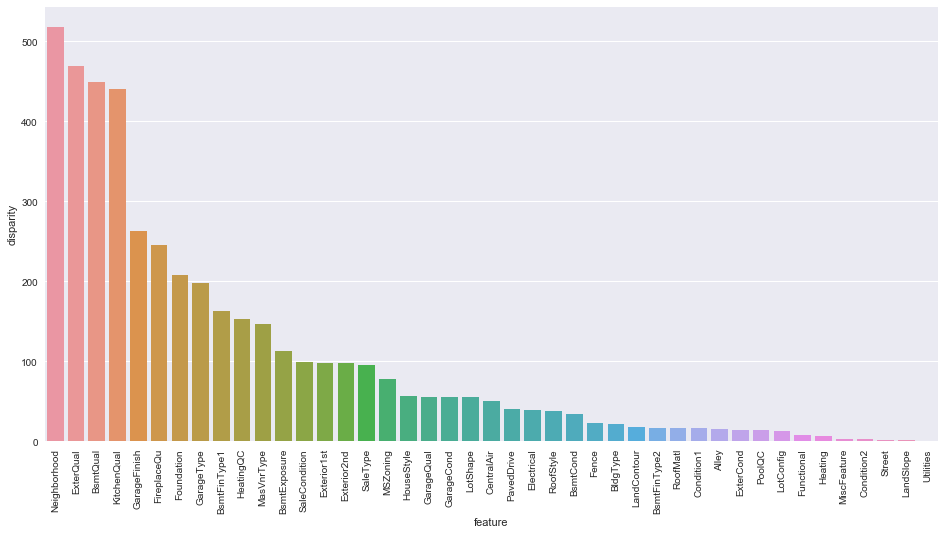

In [212]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot(data=a, x='feature', y='disparity')

x = plt.xticks(rotation=90)